In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
from collections import Counter



In [2]:
###Dates
today = datetime.today()
start_ = today - relativedelta(years = 30)

In [3]:
####Get 10 Year Rates Table with Yahoo Finance API

Ten_Y_Rates = yf.Ticker('^TNX')
Ten_Y_rates_table = Ten_Y_Rates.history(start = start_, end = today)
Ten_Y_rates_table.reset_index(inplace=True)
Ten_Y_rates_table.Date = pd.to_datetime(Ten_Y_rates_table.Date)
#Ten_Y_rates_table = Ten_Y_rates_table.set_index('Date')
Ten_Y_rates_table = Ten_Y_rates_table.drop(columns=['Volume', 'Dividends', 'Stock Splits'])

In [4]:
###Manipulate the 10 Year Rates Table

Ten_Y_rates_table['Day_Range'] = Ten_Y_rates_table['High'] - Ten_Y_rates_table['Low']
Ten_Y_rates_table['Intraday_Change'] = Ten_Y_rates_table['Close'] - Ten_Y_rates_table['Open']
Ten_Y_rates_table['Daily Change'] = Ten_Y_rates_table['Close'].diff()
Ten_Y_rates_table['Range_Daily_Change'] = Ten_Y_rates_table['Day_Range'].diff()

In [5]:
####data from excel spreadsheet
FOMC_table = pd.read_excel('FOMC_Dissents_Data copy.xlsx')
FOMC_table = FOMC_table.iloc[:,:4]
FOMC_table = FOMC_table.drop('Year', axis = 1)
FOMC_table = FOMC_table.drop('Chair', axis = 1)

###Change 'FOMC MEETING' TO Date to merge the two data frames
FOMC_table.rename(columns = {"FOMC Meeting": "Date"}, inplace = True)
###Creates Dummy Variable
FOMC_table['Fed Decision Date'] = 1

def convert(series):
    if series == 'N':
        series = 0
    if series == 'Y':
        series = 1
    return series

FOMC_table['Dissent (Y or N)'] = FOMC_table['Dissent (Y or N)'].apply(convert)

In [6]:
###Join Ten_Year_Table with FOMC Table on Date and FOMC Meeting
new_table = Ten_Y_rates_table.merge(FOMC_table, on='Date', how='left')
###Make missing values for Decision Date equal to 0

In [7]:
new_table['Fed Decision Date'] = new_table['Fed Decision Date'].fillna(0)
new_table['Fed Dissent (Y or N)'] = new_table['Dissent (Y or N)'].fillna(0)
Comp_1 = new_table.drop('Dissent (Y or N)', axis = 1)



VOL is defined as the standard deviation of the log return of 10 year interest rates.

Multiple rolling periods will be used: 3, 5


In [8]:
### Get volatility of data

Comp_1['Log returns'] = np.log(Comp_1['Close']/Comp_1['Close'].shift())
Comp_1['VOL_3'] = Comp_1['Log returns'].rolling(3).std()
Comp_1['VOL_5'] = Comp_1['Log returns'].rolling(5).std()
df = Comp_1

df2 = df



## Graph 3 Day VOL on Fed Date and Non Fed Date

Text(0.5, 1.0, 'Impact of Fed Decision Dates on 3 Day Rolling Volatility')

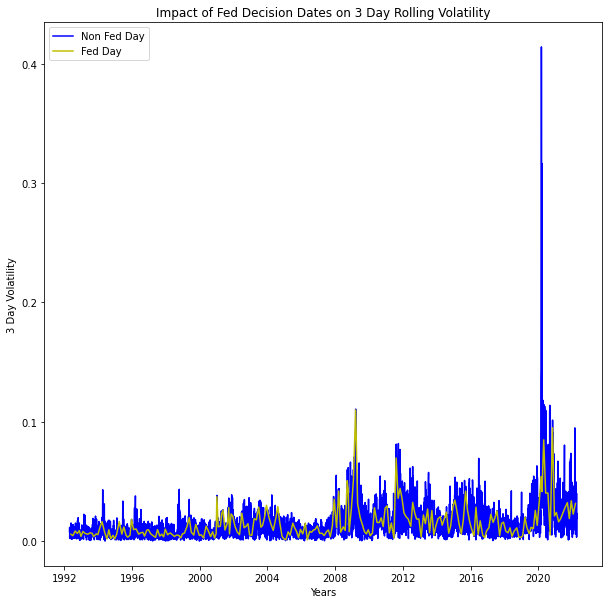

In [9]:
df_FED = df[df['Fed Decision Date'] == 1]
df_non_FED = df[df['Fed Decision Date'] == 0]

plt.figure(figsize=(10,10)) 
plt.plot(df_non_FED['Date'], df_non_FED['VOL_3'], color = 'b', label = 'Non Fed Day')
plt.plot(df_FED['Date'], df_FED['VOL_3'], color = 'y', label = 'Fed Day')
plt.legend()
plt.xlabel('Years')
plt.ylabel('3 Day Volatility')
plt.title('Impact of Fed Decision Dates on 3 Day Rolling Volatility')

In [10]:
###make new variable - within 3 days of fed decision or not
###if the value is 1, mark the previus 3 days value as 1 and the next 3 days 1


for index, row in df2.iterrows():
    if row['Fed Decision Date'] == 1:
        df.at[(index),'Fed Decision Date'] = 0
        df.at[(index - 1),'Fed Decision Date'] = 1
        df.at[(index - 2),'Fed Decision Date'] = 1
        df.at[(index - 3),'Fed Decision Date'] = 1
        df.at[(index + 1),'Fed Decision Date'] = 1
        df.at[(index + 2),'Fed Decision Date'] = 1
        df.at[(index + 3),'Fed Decision Date'] = 1
        
df['Within_3 + Fed_date'] = df2['Fed Decision Date']
Counter(df['Within_3 + Fed_date'])


Counter({0.0: 6063, 1.0: 1470})

Text(0.5, 1.0, 'Impact of Fed Decision Dates on Past and Future Days')

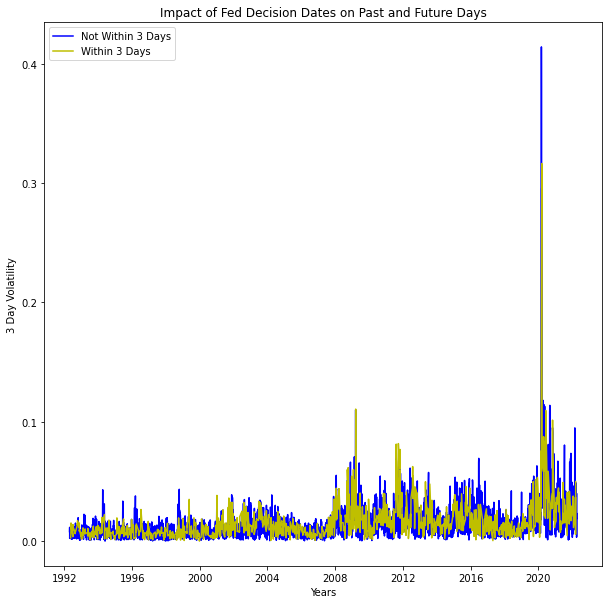

In [11]:
df_FED_3 = df[df['Within_3 + Fed_date'] == 1]
df_non_FED_3 = df[df['Within_3 + Fed_date'] == 0]



plt.figure(figsize=(10,10)) 
plt.plot(df_non_FED_3['Date'], df_non_FED_3['VOL_3'], color = 'b', label = 'Not Within 3 Days')
plt.plot(df_FED_3['Date'], df_FED_3['VOL_3'], color = 'y', label = 'Within 3 Days')
plt.legend()
plt.xlabel('Years')
plt.ylabel('3 Day Volatility')
plt.title('Impact of Fed Decision Dates on Past and Future Days')